#### Environment

In [ ]:
# !pip3 install mediapipe
!curl --output model.task "https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task"

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
project_path = "."
# project_path = "drive/MyDrive/NTU_IOT_final"
picture_path = os.path.join(project_path, "pic")
video_path = os.path.join(project_path, "video")
output_path = os.path.join(project_path, "output")
model_path = "model.task"

#### Utils

In [7]:
def get_frame_from_photo(path):
    frame = cv2.imread(path)
    if frame is None:
        print("get_frame_from_photo() failed")
    return frame

def get_frame_frome_video(path):
    cap = cv2.VideoCapture(path)

    if not cap.isOpened():
        print("get_frame_from_video() failed")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"width: {width}, height: {height}, fps: {fps}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        yield frame, timestamp_ms

    cap.release()

def process_frame(frame):
    try:
        # show_frame(frame)
        frame = frame.copy()
        processed_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        processed_frame = cv2.GaussianBlur(processed_frame, (5, 5), 0)
        processed_frame = cv2.normalize(processed_frame, None, 0, 255, cv2.NORM_MINMAX)
        # show_frame(processed_frame, "gray")
        return processed_frame
    except:
        print("process_frame() failed")
        return frame

def show_frame(frame, cmap=None):
    plt.figure(figsize=(12, 8))
    plt.imshow(frame, cmap=cmap)
    plt.axis("off")
    plt.show()

def mark_cross(frame, x, y, size=8, color=(255, 0, 0), thickness=2):
    cv2.line(frame, (x - size, y - size), (x + size, y + size), color, thickness)
    cv2.line(frame, (x - size, y + size), (x + size, y - size), color, thickness)
    return frame

def add_text(frame, text, x, y, font_scale=0.8, color=(255, 0, 0), thickness=2):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, text, (x, y), font, font_scale, color, thickness)
    return frame

#### Crop Keyboard

In [14]:
def crop_keyboard(frame, n_scanlines=100, white_threshold=200, min_transactions=35, min_white_ratio=0.3):
	processed_frame = process_frame(frame)
	# show_frame(processed_frame)
	height, width = processed_frame.shape
	scanline_positions = np.linspace(0, height - 1, n_scanlines).astype(int)
	key_areas = []

	for y in scanline_positions:
		scanline = processed_frame[y, :]

		binary_line = (scanline > white_threshold).astype(int)
		diff = np.abs(np.diff(binary_line))
		transitions = np.sum(diff)
		white_ratio = np.sum(binary_line) / width

		if transitions > min_transactions and white_ratio > min_white_ratio:
			key_areas.append(y)
	if key_areas:
		top = max(0, min(key_areas) + int(height * 1 / n_scanlines))
		bottom = min(height, max(key_areas) - int(height * 1 / n_scanlines))
		return frame[top:bottom, :], top, bottom
	else:
		print("keyboard not found")
		return None

.\pic\test.jpg


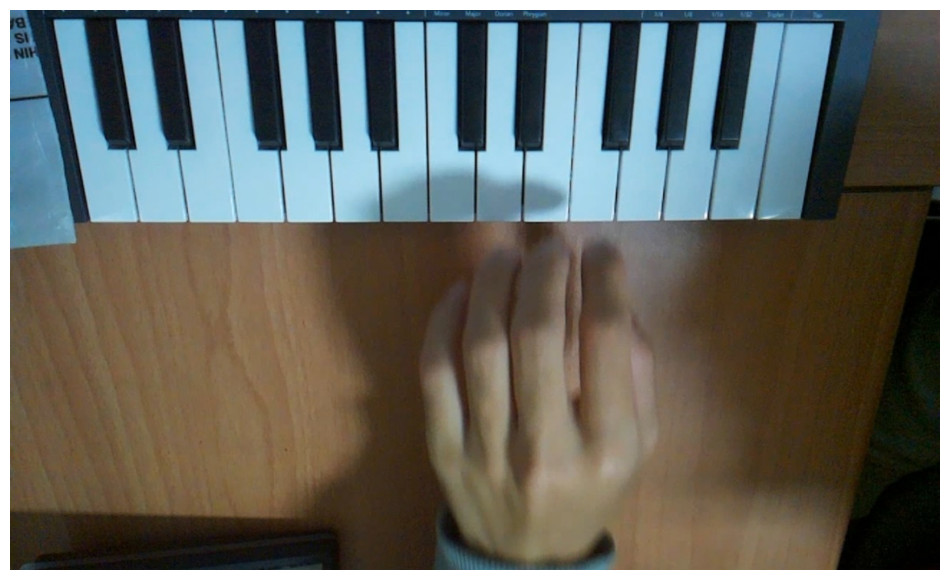

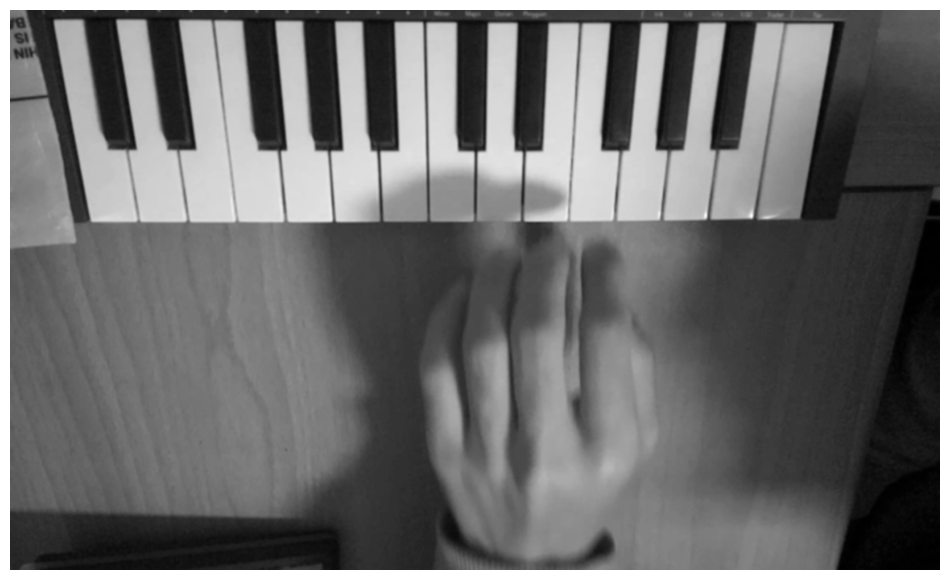

keyboard not found


TypeError: cannot unpack non-iterable NoneType object

In [15]:
show = True
keyboards = []

for filename in os.listdir(picture_path):
    if filename.endswith(".jpg"):
        path = os.path.join(picture_path, filename)
        print(path)
        frame = get_frame_from_photo(path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        keyboard, _, _ = crop_keyboard(frame)
        keyboard = cv2.resize(keyboard, (int(keyboard.shape[1] * 256 / keyboard.shape[0]), 256))
        keyboards.append(keyboard)
        if show:
            print(f"original frame: {path}")
            show_frame(frame)
            print(f"crop frame: {path}")
            show_frame(keyboard)

#### Label Key

In [ ]:
def show_grayscale_distr(gray_frame):
    hist = cv2.calcHist([gray_frame], [0], None, [256], [0, 256])
    plt.figure(figsize=(8, 4))
    plt.title("Grayscale Distribution")
    plt.plot(hist, color="black")
    plt.xlabel("Gray Level")
    plt.ylabel("Pixel Count")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def get_key_contour(frame, kernel_size=5, kx=20, ky=2, crop=5, threshold=5000):
    b_channel, g_channel, r_channel = cv2.split(frame)
    frame_mn_gray = np.minimum(np.minimum(b_channel, g_channel), r_channel)

    sobelx = cv2.Sobel(frame_mn_gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(frame_mn_gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel = np.sqrt(kx * sobelx ** 2 + ky * sobely ** 2)

    contour = np.zeros_like(sobel, dtype=np.uint8)
    contour[sobel <= threshold] = 255
    contour[sobel > threshold] = 0
    contour[:crop, :] = 0
    contour[-crop:, :] = 0
    contour[:, :crop] = 0
    contour[:, -crop:] = 0

    return contour

def get_white_key_component(frame, min_area=2000, max_area=12000, min_height=220, max_width=120):
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(frame)

    avg_centorid = np.mean(centroids[1:, 1])
    for i in range(1, n_labels):
        if abs(avg_centorid - centroids[i, 1]) > 30 or stats[i, 4] < min_area or stats[i, 4] > max_area or stats[i, 2] > max_width or stats[i, 3] < min_height:
            labels[labels == i] = 0

    labels[labels > 0] = 255
    labels = labels.astype(np.uint8)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels)
    labels = labels.astype(np.uint8)

    return n_labels, labels, stats, centroids

def get_black_key_component(frame, min_width=30, max_width=90, max_height=220):
    height, width = frame.shape
    new_frame = np.zeros_like(frame)
    for x in range(height):
        start_idx = -1
        for y in range(width):
            if frame[x, y] == 0:
                if start_idx == -1:
                    start_idx = y
            else:
                if start_idx != -1:
                    length = y - start_idx
                    if min_width <= length and length <= max_width:
                        new_frame[x, start_idx:y] = 255
                    start_idx = -1

        if start_idx != -1:
            length = width - start_idx
            if length <= max_width:
                new_frame[x, start_idx:width] = 255

    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_frame)
    avg_centorid = np.mean(centroids[1:, 1])
    for i in range(1, n_labels):
        if abs(avg_centorid - centroids[i, 1]) > 30 or i in labels and np.argwhere(labels == i)[:, 0].max() > max_height:
            labels[labels == i] = 0

    labels[labels > 0] = 255
    show_frame(labels, "gray")
    labels = labels.astype(np.uint8)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels)
    labels = labels.astype(np.uint8)

    return n_labels, labels, stats, centroids

In [ ]:
show = True

for keyboard in keyboards:
    contour = get_key_contour(keyboard)
    n_labels1, labels1, stats1, centroids1 = get_white_key_component(contour)
    n_labels2, labels2, stats2, centroids2 = get_black_key_component(labels1)

    labels2_offset = labels2 + n_labels1 - 1
    labels2_offset[labels2_offset == n_labels1] = 0

    labels = labels1 + (labels2 + n_labels1)
    n_labels = n_labels1 + n_labels2 - 1
    stats = np.concatenate((stats1, stats2[1:]), axis=0)
    centroids = np.concatenate((centroids1, centroids2[1:]), axis=0)

    order = centroids[1:, 0].argsort() + 1

    if show:
        show_frame(contour, "gray")

        print(f"number of keys: {n_labels - 1}")
        show_labels = cv2.cvtColor(labels.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        show_labels[labels1 > 0] = 255
        for idx, i in enumerate(order):
            color = (255, 0, 0)
            if i >= n_labels1:
                color = (0, 255, 0)
            show_labels = mark_cross(show_labels, int(centroids[i][0]), int(centroids[i][1]), color=color)
            show_labels = add_text(show_labels, f"{idx}", int(centroids[i][0]) - 10, int(centroids[i][1] + 40), color=color)

        show_frame(show_labels, "gray")

#### Hand Detection

In [ ]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="model.task"),
    running_mode=VisionRunningMode.VIDEO
)

def draw_landmarks_on_image(frame, hand_landmarks, line_color=(0, 255, 0), circle_color=(255, 0, 0)):
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),
        (0, 5), (5, 6), (6, 7), (7, 8),
        (0, 9), (9, 10), (10, 11), (11, 12),
        (0, 13), (13, 14), (14, 15), (15, 16),
        (0, 17), (17, 18), (18, 19), (19, 20)
    ]

    frame = frame.copy()
    height, width, _ = frame.shape
    for landmarks in hand_landmarks:
        for start_idx, end_idx in HAND_CONNECTIONS:
            x1, y1 = int(landmarks[start_idx].x * width), int(landmarks[start_idx].y * height)
            x2, y2 = int(landmarks[end_idx].x * width), int(landmarks[end_idx].y * height)
            cv2.line(frame, (x1, y1), (x2, y2), line_color, 3)
        for idx, landmark in enumerate(landmarks):
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            cv2.circle(frame, (x, y), 5, circle_color, -1)

    return frame

def get_difference_mask(frame1, frame2, threshold=30):
    b_channel, g_channel, r_channel = cv2.split(frame1)
    frame1_mn_gray = np.minimum(np.minimum(b_channel, g_channel), r_channel)
    b_channel, g_channel, r_channel = cv2.split(frame2)
    frame2_mn_gray = np.minimum(np.minimum(b_channel, g_channel), r_channel)

    diff = np.abs(frame1_mn_gray.astype(np.int32) - frame2_mn_gray.astype(np.int32)).astype(np.uint8)
    diff[diff < threshold] = 0
    return diff


#### Test on Video

In [ ]:
show = True
saved = False


for filename in os.listdir(video_path):
    if filename.endswith("33.mp4"):
        path = os.path.join(video_path, filename)
        landmarker = HandLandmarker.create_from_options(options)

        if saved:
            cap = cv2.VideoCapture(path)
            if not cap.isOpened():
                print(f"fail to open {path} video")
                continue
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            print(f"width: {width}, height: {height}, fps: {fps}")
            cap.release()
            fourcc = cv2.VideoWriter_fourcc(*"mp4v")
            out = cv2.VideoWriter(f"{output_path}/test.mp4", fourcc, fps, (width, height))

        keyboard_info = None
        first_frame = None
        for frame, timestamp in get_frame_frome_video(path):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if first_frame is None:
                first_frame = frame.copy()

            if not keyboard_info:
                keyboard, top, bottom = crop_keyboard(frame, white_threshold=180, min_transactions=10, min_white_ratio=0.3)
                # if bottom - top + 1 > 256:
                #     keyboard = cv2.resize(keyboard, (int(keyboard.shape[1] * 256 / keyboard.shape[0]), 256))

                contour = get_key_contour(keyboard, kx=30, ky=3)
                show_frame(contour, "gray")

                n_labels1, labels1, stats1, centroids1 = get_white_key_component(contour, min_area=3000, max_area=14000)
                n_labels2, labels2, stats2, centroids2 = get_black_key_component(labels1)

                print(n_labels1, n_labels2)
                labels2_offset = labels2 + n_labels1 - 1
                labels2_offset[labels2_offset == (n_labels1 - 1)] = 0
                labels = labels1 + (labels2_offset)
                n_labels = n_labels1 + n_labels2 - 1
                stats = np.concatenate((stats1, stats2[1:]), axis=0)
                centroids = np.concatenate((centroids1, centroids2[1:]), axis=0)

                order = centroids[1:, 0].argsort() + 1
                reverse_order = [0 for i in range(len(order) + 1)]
                print(order)
                print(reverse_order)
                for idx, i in enumerate(order):
                    reverse_order[i] = idx

                keyboard_info = {
                    "top": top,
                    "bottom": bottom,
                    "labels": labels,
                    "centroids": centroids,
                    "order": order,
                    "reverse_order": reverse_order,
                    "stats": stats
                }

                if show:
                    show_frame(frame)
                    show_frame(keyboard)
                    show_frame(contour, "gray")
                    print(f"number of keys: {n_labels - 1}")
                    show_labels = cv2.cvtColor(labels.astype(np.uint8), cv2.COLOR_GRAY2BGR)
                    show_labels[labels1 > 0] = 255
                    for idx, i in enumerate(order):
                        color = (255, 0, 0)
                        if i >= n_labels1:
                            color = (0, 255, 0)
                        show_labels = mark_cross(show_labels, int(centroids[i][0]), int(centroids[i][1]), color=color)
                        show_labels = add_text(show_labels, f"{idx}", int(centroids[i][0]) - 10, int(centroids[i][1] + 40), color=color)

                    show_frame(show_labels)

            mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            result = landmarker.detect_for_video(mp_frame, mp.Timestamp.from_seconds(timestamp / 1000).value)
            landmark_frame = frame
            if result.hand_landmarks:
                landmark_frame = draw_landmarks_on_image(frame, result.hand_landmarks)
                # show_frame(landmark_frame)

            if keyboard_info:
                top = keyboard_info["top"]
                bottom = keyboard_info["bottom"]
                labels = keyboard_info["labels"]
                reverse_order = keyboard_info["reverse_order"]
                stats = keyboard_info["stats"]

                diff1 = get_difference_mask(first_frame[top:bottom, :], frame[top:bottom, :])
                cnt1 = np.bincount(labels[diff1 != 0], minlength=np.max(labels) + 1)
                diff2 = get_difference_mask(first_frame[top:top + int((bottom - top) * 0.2), :], frame[top:top + int((bottom - top) * 0.2), :])
                cnt2 = np.bincount(labels[top:top + int((bottom - top) * 0.2), :][diff2 != 0], minlength=np.max(labels) + 1)

                frame = show_labels.copy()
                # print(frame.shape)
                for i in range(1, len(cnt1)):
                    if cnt1[i] / stats[reverse_order[i], 4] > 0.1 and cnt2[i] / stats[reverse_order[i], 4] > 0.011:
                        print(f"hit {reverse_order[i]} key at {timestamp} msec")
                        landmark_frame[top:bottom, :][labels == i] = 255 - (255 - np.array([15, 222, 42], dtype=np.float32) * 0.5 + 255 - landmark_frame[top:bottom, :][labels == i].astype(np.float32) * 0.5).astype(np.uint8)
                        show_frame(landmark_frame)

                        # print(landmark_frame.shape)
                        # print(labels.shape)

                        # check_mark = np.all(frame == (255, 0, 0), axis=-1)
                        # frame[labels == i] = 255 - (255 - np.array([15, 222, 42], dtype=np.float32) * 0.5 + 255 - frame[labels == i].astype(np.float32) * 0.5).astype(np.uint8)
                        # frame[check_mark] = (255, 0, 0)

                        # show_frame(landmark_frame)
                        # print(f"{reverse_order[i]}: {cnt1[i] / stats[reverse_order[i], 4] * 100:.2f}%")
                        # print(f"{reverse_order[i]}: {cnt2[i] / stats[reverse_order[i], 4] * 100:.2f}%")
                #     if cnt1[i] > 300:
                #         print(f"{timestamp}")
                #         print(f"{reverse_order[i]}: {cnt1[i] / stats[reverse_order[i], 4] * 100:.2f}%")
                #         print(f"{reverse_order[i]}: {cnt2[i] / stats[reverse_order[i], 4] * 100:.2f}%")

                # if result.hand_landmarks:
                #     tmp_frame = landmark_frame.copy()
                #     top += 15
                #     bottom += 15
                #     tmp_frame[top:bottom, :] = frame
                #     tmp_frame[:top, :] = (255, 255, 255)
                #     tmp_frame[bottom:, :] = (255, 255, 255)
                #     frame = draw_landmarks_on_image(tmp_frame, result.hand_landmarks, line_color=(219, 136, 63), circle_color=(131, 83, 41))[top:bottom, :]
                    # show_frame(frame)

                # show_frame(landmark_frame)
                # show_frame(diff1, "gray")
                # show_frame(diff2, "gray")

            if saved:
                print(f"timestamp: {timestamp}")

                frame = cv2.cvtColor(landmark_frame, cv2.COLOR_RGB2BGR)
                # print(frame.shape)
                # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                # show_frame(frame)
                out.write(frame)

        if saved:
            print("saved output video")
            out.release()
        cv2.destroyAllWindows()

